# Самостоятельная работа по блоку OnDemand-3
## Сплит-тестирование введения скидки 30% на подписку
### Задача:
1. Рассчитать, насколько различаются конверсия, средний чек и ARPU пользователей в группах А и Б (ID теста 127, даты проведения: с 2019-08-05 до 2019-08-11 включительно).
2. Сформировать выводы по анализу.

Импортируем необходимые нам библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from datetime import datetime

Загружаем файл пользователей с разделением по группам и тестам. Выбираем необходимый нам тест.

In [2]:
ab_test_groups = pd.read_csv('ab_test_groups.csv')
ab_test_groups.head()

,user_id,grp,ab_test_id
0,1,B,132
1,2,A,132
2,3,B,132
3,4,A,132
4,5,B,132


In [3]:
ab_test_groups = ab_test_groups.loc[ab_test_groups.ab_test_id == 127]
ab_test_groups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153232 entries, 11999 to 165230
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     153232 non-null  int64 
 1   grp         153232 non-null  object
 2   ab_test_id  153232 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.7+ MB


Загружаем файл с платежами. Выделяем необходимый нам период и оставляем только значимые столбцы - id пользователя и сумму.

In [4]:
payments = pd.read_csv('payments.csv')
payments.head()

,payment_id,user_id,price,created_at,tariff
0,1,77831,200.0,2019-08-05 00:00:54,month
1,2,84576,200.0,2019-08-05 00:01:05,month
2,3,40981,140.0,2019-08-05 00:03:47,month_30off
3,4,130565,140.0,2019-08-05 00:09:33,month_30off
4,5,34758,700.0,2019-08-05 00:12:16,year_30off


In [5]:
payments = payments.loc[(payments.created_at.astype(str) >= '2019-08-05')&
            (payments.created_at.astype(str) < '2019-08-12'), ['user_id', 'price']]
payments.head()

,user_id,price
0,77831,200.0
1,84576,200.0
2,40981,140.0
3,130565,140.0
4,34758,700.0


На случай, если у каких-то пользователей больше одного платежа, сгруппируем их.

In [6]:
payments = payments.groupby('user_id', as_index = False).agg({'price':'sum'})
payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13706 entries, 0 to 13705
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  13706 non-null  int64  
 1   price    13706 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 321.2 KB


Объединяем таблицы.

In [7]:
ab_data = ab_test_groups.merge(payments, on = 'user_id', how = 'left')
ab_data.head()

,user_id,grp,ab_test_id,price
0,1,B,127,140.0
1,2,B,127,NaN
2,3,B,127,NaN
3,4,B,127,NaN
4,5,A,127,NaN


Аггрегируем данные в отдельный датафрейм.

In [8]:
ab_summary = ab_data.groupby('grp').agg({'user_id':'count', 'price':'count'}) #Агрегация данных
ab_summary.rename(columns={'user_id':'users_count', 'price':'buyers_count'}, inplace = True) #Переименовывание столбцов
ab_summary

,users_count,buyers_count
grp,,
A,76605,4279
B,76627,9427


Уже по таблице ясно, что разделение пользователей 50/50, однако посмотрим на точную цифру пропорции.

In [9]:
ab_summary.loc[ab_summary.index == 'A', 'users_count'].sum()/ab_summary.users_count.sum()

0.4999282134280046

Добавляем колонку с конверсией.

In [10]:
ab_summary['conversion'] = ab_summary.buyers_count/ab_summary.users_count
ab_summary

,users_count,buyers_count,conversion
grp,,,
A,76605,4279,0.055858
B,76627,9427,0.123025


Также посчитаем средний чек покупки в каждой группе.

In [11]:
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'mean'}).rename(columns = {'price':'avg_bill'}), 
                 left_index = True, right_index = True) #Сделали агрегацию и прикрепили её к ab_summary
ab_summary

,users_count,buyers_count,conversion,avg_bill
grp,,,,
A,76605,4279,0.055858,396.120589
B,76627,9427,0.123025,348.804498


Посчитаем ARPU и дополнительную выручку

In [12]:
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'sum'}).rename(columns = {'price':'revenue'}), 
                 left_index = True, right_index = True) # Сделали агрегацию и прикрепили её к ab_summary
ab_summary['ARPU'] = ab_summary.revenue/ab_summary.users_count
ab_summary['Доп. выручка'] = ab_summary.users_count*(ab_summary.ARPU - ab_summary.loc['A', 'ARPU'])
ab_summary

,users_count,buyers_count,conversion,avg_bill,revenue,ARPU,Доп. выручка
grp,,,,,,,
A,76605,4279,0.055858,396.120589,1695000.0,22.126493,0.000000e+00
B,76627,9427,0.123025,348.804498,3288180.0,42.911506,1.592693e+06


In [13]:
print(f"Дополнительная выручка в группе В: {ab_summary['Доп. выручка']['B'].round()}")
print(f"Разница в ARPU между группами А и В: {ab_summary.ARPU.B - ab_summary.ARPU.A}")

Дополнительная выручка в группе В: 1592693.0
Разница в ARPU между группами А и В: 20.785013339331144


Итак, рассчитаем значимость изменения конверсии.

Конверсия — бинарная величина (пользователь либо купил, либо нет), поэтому для подсчёта значимости нужно использовать Z-тест.

In [14]:
z = ztest(ab_data.loc[ab_data.grp == 'A', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0),#Конверсии пользователей группы А
     ab_data.loc[ab_data.grp == 'B', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0) #Конверсии пользователей группы B
     ) 
print(f"Z-stat: {z[0]}\np-value: {z[1]}")

Z-stat: -46.38627328408593
p-value: 0.0


Нам нужно как раз p-значение, которое в данном случае равно нулю, что позволяет говорить о фактическом улучшении конверсии.

У нас ограниченное количество цен на подписки, поэтому очевидно, что показатели распределены ненормально. Давайте визуализируем этот факт и проверим его истинность с помощью статистического теста Шапиро-Вилка для распределения средних чеков и покупок.

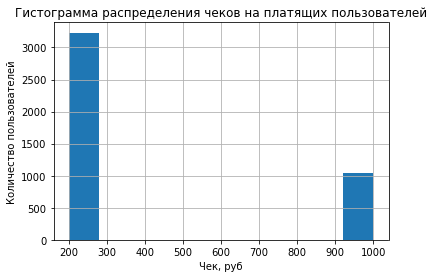

Shapiro-Wilk p-value is 0.0


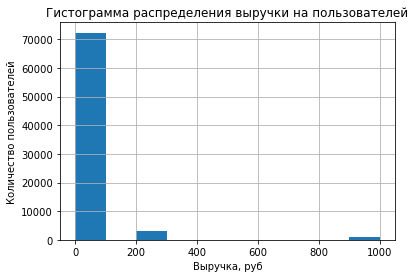

Shapiro-Wilk p-value is 0.0


D:\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [15]:
ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].dropna().hist()
ax.set_xlabel('Чек, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения чеков на платящих пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].dropna())[1])

ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0).hist()
ax.set_xlabel('Выручка, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения выручки на пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0))[1])

И визуальный анализ, и тест Шапиро-Вилка на нормальность говорят нам, что распределение не является нормальным.

Так как распределения признаков не бинарные (0-1) и не нормальные, нужно использовать для сравнения средних не только T-тест, но и непараметрический U-тест Манна-Уитни.

Зачем это нужно?

U-тест сообщит нам, различаются ли сами распределения, а T-тест покажет, различаются ли средние этих распределений. При сравнении средних величин (например, ARPU) обычно важнее показатель p-значение для Т-теста: если он меньше 0,05, а p-значение теста Манна-Уитни больше 0,05, то это всё равно говорит о значимых различиях показателей.

In [16]:
print(stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(), ab_data.loc[ab_data.grp == 'B', 'price'].dropna()),
stats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(), ab_data.loc[ab_data.grp == 'B', 'price'].dropna())
      , sep = '\n')

MannwhitneyuResult(statistic=11353450.0, pvalue=0.0)
Ttest_indResult(statistic=8.681488291725874, pvalue=4.342920451712972e-18)


Как мы видим, средние чеки также значимо различаются (так как p-значение << 0.05, близки или равны нулю) по каждому из тестов.

In [17]:
print(stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0), ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0)),
      stats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0), ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0)),
     sep = '\n')

MannwhitneyuResult(statistic=2746687083.0, pvalue=0.0)
Ttest_indResult(statistic=-29.893345238870868, pvalue=8.818064407002295e-196)


С ARPU ситуация еще более ясная. Оба теста однозначно говорят, что распределения разные.

In [18]:
#Важные функции для получения доверительных интервалов
def get_conf_interval(data, conf_level = 0.95):  
# Считает доверительные интервалы для средних
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        return (buf[1] - buf[0])/2
    
def get_conf_interval_z(succ, tot):  
#Считает доверительные интервалы для бинарных величин
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]

In [19]:
get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)) 
#Доверительный полуинтервал для ARPU пользователей в группе А

0.8641428736438357

In [20]:
#Составляем словарь с доверительными интервалами для каждой метрики и для каждой группы
conf_intervals = {'ARPU':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0))},
                  'conversion':{'A':get_conf_interval_z(ab_data.loc[ab_data.grp == 'A', 'price'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'A', 'user_id'].count()),
                               'B':get_conf_interval_z(ab_data.loc[ab_data.grp == 'B', 'price'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'B', 'user_id'].count())},
                  'avg_bill':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].dropna()),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].dropna())}
                 }
conf_intervals

{'ARPU': {'A': 0.8641428736438357, 'B': 1.0537383983825563},
 'conversion': {'A': 0.0032524511174824022, 'B': 0.004651325604805509},
 'avg_bill': {'A': 10.315428393735829, 'B': 5.467446406040892}}

In [21]:
#Удобная функция для подстановки подписей на barplot
def set_labels(axes):  
#Расставляет подписи столбцов на барплоты
    y0, y1 = axes.get_ybound()  
#Размер графика по оси Y
    y_shift = 0.15* (y1 - y0)  
#Дополнительное место под надписи

    for i, rect in enumerate(axes.patches):  
#По всем нарисованным прямоугольникам
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
        x = rect.get_x() + rect.get_width() / 2  
#Посередине прямоугольника
        y = height + y_shift * 0.8  
#Над прямоугольником в середине доп. места
        if height < 0:
            y = y_shift * 0.8 
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)

In [22]:
plot_summary = ab_summary.T 
#Транспонированная таблица для удобства использования
significant_changes = ['conversion', 'avg_bill'] 
#Метрики со статзначимыми различиями

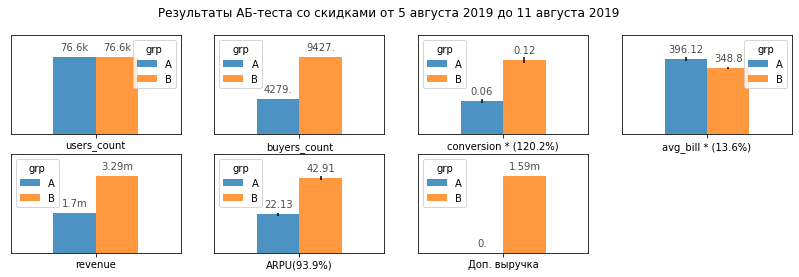

In [23]:
from matplotlib import gridspec
from math import ceil

ax = []
#Массив для складирования графиков
n_pict_in_line = 4
#Количество картинок в одной линии

gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line)
#Создаём сетку для графиков
fig = plt.figure(figsize=(n_pict_in_line*3 + 2,
                          ceil(len(plot_summary) / n_pict_in_line) * 2))

##Считаем изменение метрики в процентах
delta_percent = {}
for row in plot_summary.index:  
    if 'users_count' != row and 'buyers_count' != row and 'revenue' != row and "Доп. выручка" != row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'
        
fig.suptitle('Результаты АБ-теста со скидками от 5 августа 2019 до 11 августа 2019')

##Строим графики
for i, col in enumerate(plot_summary.index):
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line]))
#Добавляем subplot в нужную клетку
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8,
#Строим график в нужной клетке
                                   yerr=conf_intervals[col] if col in conf_intervals else 0) 
    
   
#Редактируем подпись к графику, чтобы в ней хранилась информация о значимости различий 
    stars = ' * ' if col in significant_changes else '' 
    ticks = ax[-1].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[-1].set_xticklabels(ticks)
    ax[-1].set_yticks([])
    set_labels(axes=ax[i])

In [24]:
ab_summary[['avg_bill','revenue','ARPU','Доп. выручка']] = ab_summary[['avg_bill','revenue','ARPU','Доп. выручка']].round(2)
ab_summary

,users_count,buyers_count,conversion,avg_bill,revenue,ARPU,Доп. выручка
grp,,,,,,,
A,76605,4279,0.055858,396.12,1695000.0,22.13,0.00
B,76627,9427,0.123025,348.80,3288180.0,42.91,1592693.22


In [25]:
print(f"Конверсия группы А: {ab_summary.conversion.A.round(3)}\nКонверсия группы В: {ab_summary.conversion.B.round(3)} ({(ab_summary.conversion.B - ab_summary.conversion.A)/ab_summary.conversion.A:+.2%})\n")
print(f"Средний чек группы А: {ab_summary.avg_bill.A}\nСредний чек группы B: {ab_summary.avg_bill.B} ({(ab_summary.avg_bill.B - ab_summary.avg_bill.A) / ab_summary.avg_bill.B:+.2%})\n")
print(f"ARPU группы А: {ab_summary.ARPU.A}\nARPU группы B: {ab_summary.ARPU.B} ({(ab_summary.ARPU.B - ab_summary.ARPU.A) / ab_summary.ARPU.A:+.2%})")

Конверсия группы А: 0.056
Конверсия группы В: 0.123 (+120.25%)

Средний чек группы А: 396.12
Средний чек группы B: 348.8 (-13.57%)

ARPU группы А: 22.13
ARPU группы B: 42.91 (+93.90%)


# Выводы  

*Группа А - пользователи со стандартными условиями. Группа В - пользователи, получившие скидку 30%.* *Распределение пользователей в группах 50/50* 

Показатель | Группа А | Группа В | Изменение
---|---|---|---
Конверсия | 0.056 | 0.123 | +120%
Средний чек | 396.12 | 348.80 | -13.6%
ARPU | 22.13 | 42.91 | +94%
Дополнительная выручка | 0 | 1,592,693.00 |

- Тест значимо **увеличил конверсию на 120%**
- Несмотря на то что скидка в группе Б составляет 30%, средний чек упал на ~13,6%.
- Тест значимо **увеличил ARPU на 94%**
- **Дополнительная выручка** от проведенного теста составила **1,592,693.00**
- **Скидки способствуют** мгновенному **увеличению выручки**, поэтому их можно проводить время от времени.